In [1]:
import pandas as pd
import numpy as np
import pickle

import scipy

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import pairwise_distances

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from ALS import ALS

from tqdm import tqdm

In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (10,5)
matplotlib.rc("text", usetex=True)
matplotlib.rc("font", family="serif")

In [3]:
def id_lookup(metadata_df, id_val):
    is_iterable = type(id_val) != str
    
    if is_iterable:
        result = metadata_df[metadata_df['id'].isin(id_val)]
    else:
        result = metadata_df[metadata_df['id'] ==  id_val]
    
    return result[['artists', 'name', 'release_date']]


def filter_user_item(user_item_df, song_threshold = 1, pl_threshold = 30):
    if type(pl_threshold) == tuple:
        lower, upper = pl_threshold
    else:
        lower = pl_threshold
        upper = np.inf
    
    mask = np.where(user_item_df.sum() > song_threshold, True, False)
    user_item_df = user_item_df.iloc[:,mask]
    user_item_df = user_item_df.loc[(user_item_df.sum(axis=1) >= lower) & (user_item_df.sum(axis=1) <= upper)]
    
    return user_item_df

In [4]:
user_item_df = pickle.load(open('user_item_df.p', 'rb'))
merge_df = pickle.load(open('merge_df.p', 'rb'))
metadata_df = pd.read_csv('../spotify_songs/all_songs.csv')

ModuleNotFoundError: No module named 'pandas.core.arrays.sparse.dtype'

In [ ]:
user_item_df.shape

(3508, 13893)

In [ ]:
user_item_df = filter_user_item(user_item_df, song_threshold = 1, pl_threshold = 10)

In [ ]:
pl_names = user_item_df.index

In [ ]:
sp_matrix = user_item_df.sparse.to_coo()

In [ ]:
user_item_df.shape

(3488, 13038)

In [ ]:
print(f'The user-item matrix is {(1 - user_item_df.sparse.density) * 100:.2f}% sparse')

The user-item matrix is 99.73% sparse


In [ ]:
hold_out_idx = []
hold_out_id = []
hold_out_ratio = 0.10

for i, row in enumerate(user_item_df.iterrows()):
    song_ids = row[1][row[1] != 0].index
    n_songs = int(len(song_ids) * hold_out_ratio)
    choice = np.random.choice(song_ids, n_songs, replace=False)
    
    song_idx = user_item_df.columns.get_indexer(choice)
    
    hold_out_idx.extend([i] * n_songs)
    hold_out_id.extend(song_idx)

In [ ]:
# hold_out_idx = (np.arange(0, user_item_df.shape[0]), np.asarray(hold_out))
hold_out = (np.asarray(hold_out_idx), np.asarray(hold_out_id))

In [ ]:
sp_mask = scipy.sparse.coo_matrix((np.ones_like(hold_out_idx), hold_out), sp_matrix.shape)

In [ ]:
sp_matrix_masked = (sp_matrix - sp_mask).tocoo()
sp_matrix_masked.eliminate_zeros()

In [ ]:
def evaluate(model, user_item_matrix, hold_out, top_n = 5):
    sp_mask = scipy.sparse.coo_matrix((np.ones_like(hold_out[0]), hold_out), user_item_matrix.shape)
    user_item_masked = (user_item_matrix - sp_mask).tocoo()
    user_item_masked.eliminate_zeros()
    
    # fit the model, using the masked user-item matrix
    model.fit(user_item_masked, n_sweep_without_progress=3, progress_eps=1e-05)
    y_hat = model.predict()
    
    # mask songs that are already in the playlist
    y_mask = np.ones(user_item_matrix.shape, dtype=bool) - user_item_masked
    y_hat_masked = np.where(y_mask, y_hat, 0)
    
    
    # generate a "top 10" of recommendations, and get the ij indices of them
    sorted_indices = (-y_hat_masked).argsort(axis=1)[:, :top_n]
    rows, _ = np.indices(sorted_indices.shape)
    max_indices = rows.flatten(), sorted_indices.flatten()
    # generate a sparse matrix of only the top n recommendations
    top_n_matrix = scipy.sparse.coo_matrix((np.ones_like(max_indices[0]), max_indices), user_item_matrix.shape)
    
    # check only the indices where the hold out indices are
    check_holdout = scipy.sparse.coo_matrix(np.where(sp_mask.todense(), top_n_matrix.todense(), 0))
    score = (check_holdout.sum(axis=1) / sp_mask.sum(axis=1)).mean()   
    
    
    # tricky way of turning each ij index into a single value
    # to see how many indices from the hold-out are in the recommendations
    # max_indices_complex = max_indices[0] + 1j * max_indices[1]
    # hold_out_complex = hold_out[0] + 1j * hold_out[1]
    # total_matched = len(np.intersect1d(max_indices_complex, hold_out_complex))
    # score = total_matched / len(hold_out[0])
    
    return score

In [ ]:
evaluate(ALS(100, sweeps=50), sp_matrix, hold_out, 20)

0.2075310037297355

In [ ]:
# score = []
# feature_count = range(10, 1000, 100)

# for i in tqdm(feature_count):
#     score.append(evaluate(ALS(i, sweeps=50), sp_matrix, hold_out, top_n = int(0.01 * user_item_df.shape[1])))


100%|██████████| 10/10 [06:41<00:00, 40.14s/it]


In [ ]:
# score

[0.3049507060835819,
 0.4447337209574544,
 0.4374466398125245,
 0.4333082085276584,
 0.4229588219895323,
 0.41711862303744557,
 0.40237603385981857,
 0.3870182339706001,
 0.37731129307690126,
 0.3670583702702227]

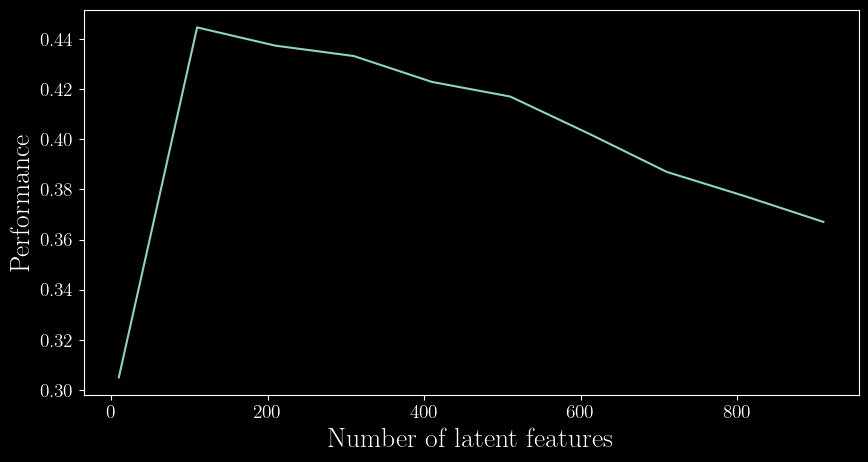

In [ ]:

# plt.rcParams["figure.figsize"] = (10,5)
# plt.plot(feature_count, score)
# plt.ylabel('Performance', fontsize=20)
# plt.xlabel('Number of latent features', fontsize=20)
# plt.tick_params(axis="both", labelsize=14)

In [ ]:
features = 110 # feature_count[np.argmax(score)]

In [ ]:
features

110

In [ ]:
mask = np.ones(sp_matrix.shape, dtype=bool) - sp_matrix_masked
als = ALS(features, sweeps = 50)
U, V = als.fit(sp_matrix_masked, True, n_sweep_without_progress=3, progress_eps=1e-05)
y_hat = als.predict()

In [ ]:
pl_idx = user_item_df.index.get_loc(81)

In [ ]:
recommendations = user_item_df.columns[(-np.where(mask, y_hat, -np.inf)).argsort()[pl_idx, :25]]

In [ ]:
def fancy_table(df, title=""):
    # Adjusting the aesthetics for a modern-looking table
    matplotlib.rcParams['figure.figsize'] = 5, 3
    sns.set(style="white", context="talk")
    matplotlib.rcParams['text.usetex'] = False

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Hide axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    # Tabulate data
    tab = ax.table(cellText=df.values, colLabels=df.columns, cellLoc = 'center', loc='center')

    # Adjust table for modern look
    tab.auto_set_font_size(False)
    tab.set_fontsize(12)
    tab.scale(1.2, 1.4)
    tab.auto_set_column_width(col=list(range(len(df.columns))))  # Adjust column widths

    # Set table colors for modern look
    colors = ["#f5f5f5", "#eeeeee"]  # Light grey colors
    for i, key in enumerate(tab.get_celld().keys()):
        cell = tab.get_celld()[key]
        if key[0] == 0:  # Header row
            cell.set_facecolor("#333333")  # Dark grey color for header
            cell.get_text().set_color("white")
        else:
            cell.set_facecolor(colors[i%2])

    plt.title(title, fontsize=16, weight='bold', color="#333333")

    plt.show()

In [ ]:
merge_df[merge_df.pid == user_item_df.index[pl_idx]][['artist_name', 'track_name', 'release_date']].head(10)

,artist_name,track_name,release_date
490,Cali Swag District,Teach Me How to Dougie,2011-07-12
1118,Big Sean,My Last,2011-01-01
1339,Lil Wayne,Drop The World,2009-01-01
1473,Drake,Headlines,2011-11-15
1486,Lil Wayne,Blunt Blowin,2011-01-01
1513,Lil Wayne,How To Love,2011-01-01
1642,Kid Cudi,Pursuit Of Happiness (nightmare),2009-09-15
3357,Lil Wayne,A Milli,2008-06-10
3370,Lil Wayne,6 Foot 7 Foot,2011-01-01
3385,Lil Wayne,Right Above It,2010-01-01


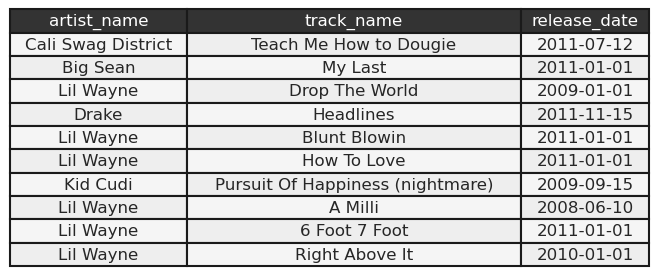

In [ ]:
fancy_table(merge_df[merge_df.pid == user_item_df.index[pl_idx]][['artist_name', 'track_name', 'release_date']].head(10))

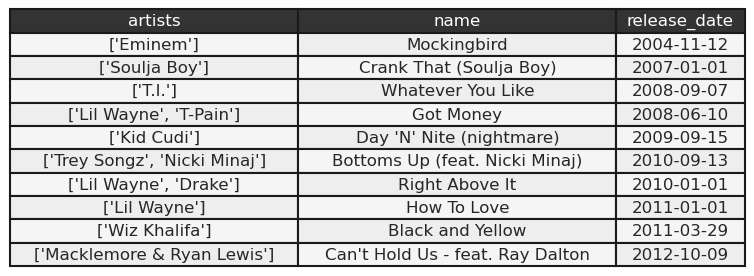

In [ ]:
fancy_table(id_lookup(metadata_df, recommendations).head(10))

In [ ]:
def song_lookup(metadata_df, song_name):
    result = metadata_df[(metadata_df['name'] == song_name)].id.iloc[0]
    return result

In [ ]:
song_dist = pairwise_distances(V, metric = 'cosine')

In [ ]:
search_idx = user_item_df.columns.get_loc(song_lookup(merge_df, 'Basket Case'))

In [ ]:
id_lookup(metadata_df, user_item_df.columns[(song_dist[search_idx]).argsort()[:10]])

,artists,name,id
14206,['Radiohead'],Creep,6b2oQwSGFkzsMtQruIWm2p
14411,['Green Day'],Basket Case,6L89mwZXSOwYl76YXfX13s
14418,['Green Day'],When I Come Around,1Dr1fXbc2IxaK1Mu8P8Khz
14837,['Tonic'],If You Could Only See,4KoNBTm9a55KgLMtEaf3n6
15007,['Foo Fighters'],Everlong,5UWwZ5lm5PKu6eKsHAGxOk
15021,['Marcy Playground'],Sex & Candy,5mkGfmJGFZpwK9nA5amOhv
15024,['blink-182'],Dammit,6WkSUgo1VdpzgtiXKlFPcY
15140,['Everclear'],I Will Buy You A New Life,2fhfoZqqTJ8jo4HvWseNfM
15166,['Third Eye Blind'],Graduate,6pLko0BJo4OmvbmPbLURsl
15413,['Lit'],My Own Worst Enemy,33iv3wnGMrrDugd7GBso1z
